In [6]:
import pandas as pd
import os

real_videos_folder = "C:\\Users\\Odwitiyo\\Downloads\\deepfake_dataset\\deepfake_dataset\\train\\real"
fake_videos_folder = "C:\\Users\\Odwitiyo\\Downloads\\deepfake_dataset\\deepfake_dataset\\train\\fake"

video_data = []

if os.path.exists(real_videos_folder):
    for filename in os.listdir(real_videos_folder):
        if filename.endswith('.mp4') or filename.endswith('.avi'): 
            video_path = os.path.join(real_videos_folder, filename)
            video_data.append({'video_path': video_path, 'label': 1})
    print(f"Processed 'real' videos from {real_videos_folder}")
else:
    print(f"Warning: 'real' folder not found at {real_videos_folder}")
    print(f"Expected path: {real_videos_folder}")

if os.path.exists(fake_videos_folder):
    for filename in os.listdir(fake_videos_folder):
        if filename.endswith('.mp4') or filename.endswith('.avi'): 
            video_path = os.path.join(fake_videos_folder, filename)
            video_data.append({'video_path': video_path, 'label': 0})
    print(f"Processed 'fake' videos from {fake_videos_folder}")
else:
    print(f"Warning: 'fake' folder not found at {fake_videos_folder}")
    print(f"Expected path: {fake_videos_folder}")

df = pd.DataFrame(video_data)

df['resnet_features'] = None 

print("\nInitial DataFrame created:")
print(df.head())

print(f"\nTotal videos found: {len(df)}")
print(f"Number of 'real' videos: {len(df[df['label'] == 1])}")
print(f"Number of 'fake' videos: {len(df[df['label'] == 0])}")

Processed 'real' videos from C:\Users\Odwitiyo\Downloads\deepfake_dataset\deepfake_dataset\train\real
Processed 'fake' videos from C:\Users\Odwitiyo\Downloads\deepfake_dataset\deepfake_dataset\train\fake

Initial DataFrame created:
                                          video_path  label resnet_features
0  C:\Users\Odwitiyo\Downloads\deepfake_dataset\d...      1            None
1  C:\Users\Odwitiyo\Downloads\deepfake_dataset\d...      1            None
2  C:\Users\Odwitiyo\Downloads\deepfake_dataset\d...      1            None
3  C:\Users\Odwitiyo\Downloads\deepfake_dataset\d...      1            None
4  C:\Users\Odwitiyo\Downloads\deepfake_dataset\d...      1            None

Total videos found: 360
Number of 'real' videos: 180
Number of 'fake' videos: 180


In [8]:
import tensorflow as tf
import numpy as np
import cv2

try:
    base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, pooling='avg')
    print("ResNet50 model loaded successfully.")
except Exception as e:
    print(f"Error loading ResNet50 model: {e}")
    print("Please ensure you have a stable internet connection to download weights.")

frames_to_extract_per_video = 20 

def extract_resnet_features(video_path, model, num_frames=10):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Warning: Could not open video file {video_path}")
        return None
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames <= 0:
        print(f"Warning: Could not get frame count for {video_path}")
        cap.release()
        return None
    if total_frames < num_frames:
        frame_indices = np.arange(total_frames)
    else:
        frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)
    frame_features = []
    for i in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if not ret:
            continue
        img = cv2.resize(frame, (224, 224))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = np.expand_dims(img, axis=0) 
        img = tf.keras.applications.resnet50.preprocess_input(img) 
        features = model.predict(img)
        frame_features.append(features.flatten()) 
    cap.release()
    if not frame_features:
        return None
    aggregated_features = np.mean(frame_features, axis=0)
    return aggregated_features
df['resnet_features'] = None
for index, row in df.iterrows():
    video_path = row['video_path']
    features = extract_resnet_features(video_path, base_model, num_frames=frames_to_extract_per_video)
    if features is not None:
        df.at[index, 'resnet_features'] = features
    else:
        df.at[index, 'resnet_features'] = np.nan 
    print(f"Processed {video_path}")

print("\nDataFrame with ResNet features:")
print(df.head())

df.to_pickle('C:\\Users\\Odwitiyo\\Downloads\\dataframe_with_resnet_features.pkl')

ResNet50 model loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Processed C:\Users\Odwitiyo\Downloads\deepfake_dataset\deepfake_dataset\train\real\01__hugging_happy.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━

In [9]:
import pandas as pd
import os

test_real_videos_folder = "C:\\Users\\Odwitiyo\\Downloads\\deepfake_dataset\\deepfake_dataset\\test\\real"  
test_fake_videos_folder = "C:\\Users\\Odwitiyo\\Downloads\\deepfake_dataset\\deepfake_dataset\\test\\fake"  

test_video_data = []

if os.path.exists(test_real_videos_folder):
    for filename in os.listdir(test_real_videos_folder):
        if filename.endswith('.mp4') or filename.endswith('.avi'): 
            video_path = os.path.join(test_real_videos_folder, filename)
            test_video_data.append({'video_path': video_path, 'label': 1})
    print(f"Processed 'real' test videos from {test_real_videos_folder}")
else:
    print(f"Warning: 'real' test folder not found at {test_real_videos_folder}")
    print(f"Expected path: {test_real_videos_folder}")

if os.path.exists(test_fake_videos_folder):
    for filename in os.listdir(test_fake_videos_folder):
        if filename.endswith('.mp4') or filename.endswith('.avi'): 
            video_path = os.path.join(test_fake_videos_folder, filename)
            test_video_data.append({'video_path': video_path, 'label': 0})
    print(f"Processed 'fake' test videos from {test_fake_videos_folder}")
else:
    print(f"Warning: 'fake' test folder not found at {test_fake_videos_folder}")
    print(f"Expected path: {test_fake_videos_folder}")

df_test = pd.DataFrame(test_video_data)

df_test['resnet_features'] = None 
for index, row in df_test.iterrows():
    video_path = row['video_path']
    features = extract_resnet_features(video_path, base_model, num_frames=frames_to_extract_per_video)
    if features is not None:
        df_test.at[index, 'resnet_features'] = features
    else:
        df_test.at[index, 'resnet_features'] = np.nan 
    print(f"Processed {video_path}")
print("\nInitial Test DataFrame created:")
print(df_test.head())

print(f"\nTotal test videos found: {len(df_test)}")
print(f"Number of 'real' test videos: {len(df_test[df_test['label'] == 1])}")
print(f"Number of 'fake' test videos: {len(df_test[df_test['label'] == 0])}")

df_test.to_pickle('C:\\Users\\Odwitiyo\\Downloads\\test_with_resnet_features.pkl')

Processed 'real' test videos from C:\Users\Odwitiyo\Downloads\deepfake_dataset\deepfake_dataset\test\real
Processed 'fake' test videos from C:\Users\Odwitiyo\Downloads\deepfake_dataset\deepfake_dataset\test\fake
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Processed C:\Us

In [1]:
import pandas as pd
df = pd.read_pickle("C:\\Users\\Odwitiyo\\Downloads\\dataframe_with_resnet_features.pkl")
df_test = pd.read_pickle("C:\\Users\\Odwitiyo\\Downloads\\test_with_resnet_features.pkl")

Determined feature dimension from data: 2048
Shape of real training data for Standard Autoencoder: (180, 2048)
Feature Dimension: 2048
Attempting to remove outliers using percentile method (15-85)...
Original data shape: (180, 2048)
Number of samples flagged as outliers: 180
Shape after removing outliers: (0, 2048)
Proceeding without outlier removal due to all data being removed.
Using original real training data shape: (180, 2048)
Real training set size for Autoencoder after outlier handling: 144
Real validation set size for Autoencoder after outlier handling: 36


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 2048)           │       264,192 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 548,768 (2.09 MB)

 Trainable params: 548,000 (2.09 MB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.0000e+00 - auc: 0.4863 - loss: 0.9381 - val_accuracy: 0.0000e+00 - val_auc: 0.5246 - val_loss: 0.8402
Epoch 2/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.0000e+00 - auc: 0.4732 - loss: 0.9506 - val_accuracy: 0.0000e+00 - val_auc: 0.5192 - val_loss: 0.8377
Epoch 3/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.0000e+00 - auc: 0.4972 - loss: 0.9324 - val_accuracy: 0.0000e+00 - val_auc: 0.5205 - val_loss: 0.8346
Epoch 4/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.0080 - auc: 0.4863 - loss: 0.9099 - val_accuracy: 0.0000e+00 - val_auc: 0.5264 - val_loss: 0.8309
Epoch 5/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.0000e+00 - auc: 0.4869 - loss: 0.9009 - val_accuracy: 0.0000e+00 - val_auc: 0.5368 - val_loss: 0.8265
Epoch 6/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.0090 - auc: 0.4998 - loss: 0.8774 - val_accuracy: 0.0000e+00 - val_auc: 0.5405 - val_loss: 0.8211
Epoch 

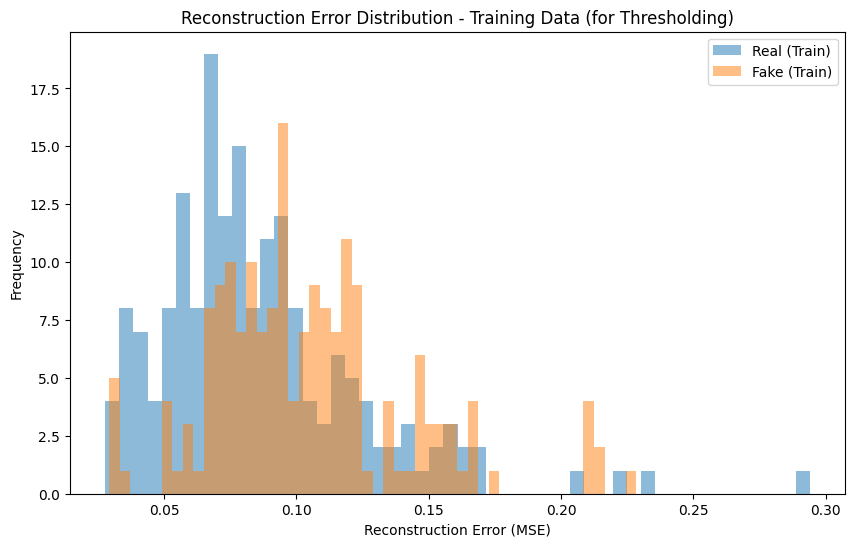


Anomaly Threshold (95th percentile of real train errors): 0.1182

Autoencoder-based Deepfake Detection Evaluation on Testing Set:
Accuracy: 0.625
AUC: 0.79

Classification Report:
              precision    recall  f1-score   support

        Fake       0.58      0.90      0.71        20
        Real       0.78      0.35      0.48        20

    accuracy                           0.62        40
   macro avg       0.68      0.62      0.59        40
weighted avg       0.68      0.62      0.59        40


Confusion Matrix:
[[18  2]
 [13  7]]


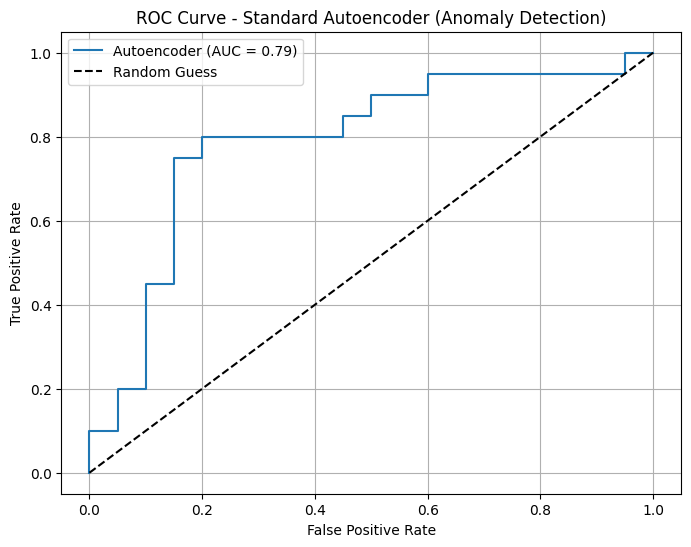

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import tensorflow as tf 

def prepare_data_for_standard_autoencoder(dataframe, column_name='resnet_features'):
    cleaned_df = dataframe.dropna(subset=[column_name, 'label'])
    features_raw = cleaned_df[column_name].tolist()
    labels_raw = cleaned_df['label'].tolist()
    if not features_raw:
        print(f"No valid features found in '{column_name}' column.")
        return np.array([]), np.array([]), 0
    feature_dimension = 0
    for feature_list in features_raw:
        if isinstance(feature_list, (list, np.ndarray)):
            feature_dimension = len(feature_list)
            print(f"Determined feature dimension from data: {feature_dimension}")
            break
    if feature_dimension == 0:
        print("Could not determine feature dimension from data.")
        return np.array([]), np.array([]), 0
    processed_features = []
    processed_labels = []
    for i, feature_list in enumerate(features_raw):
        if isinstance(feature_list, (list, np.ndarray)) and len(feature_list) == feature_dimension:
            processed_features.append(np.array(feature_list))
            processed_labels.append(labels_raw[i])
        else:
            print(f"Skipping invalid feature entry at index {i}.")
    if not processed_features:
        print("No valid features found after processing.")
        return np.array([]), np.array([]), 0
    else:
        return np.array(processed_features), np.array(processed_labels), feature_dimension
    
def remove_outliers_percentile(data, lower_percentile=1, upper_percentile=99):
    if data.shape[0] == 0:
        print("Input data to remove_outliers_percentile is empty.")
        return data
    print(f"Attempting to remove outliers using percentile method ({lower_percentile}-{upper_percentile})...")
    lower_bounds = np.percentile(data, lower_percentile, axis=0)
    upper_bounds = np.percentile(data, upper_percentile, axis=0)
    is_within_bounds = (data >= lower_bounds) & (data <= upper_bounds)
    non_outlier_mask = np.all(is_within_bounds, axis=1)
    print(f"Original data shape: {data.shape}")
    print(f"Number of samples flagged as outliers: {np.sum(~non_outlier_mask)}")
    print(f"Shape after removing outliers: {data[non_outlier_mask].shape}")
    return data[non_outlier_mask]

X_real_train_full, y_real_train_full, feature_dimension = prepare_data_for_standard_autoencoder(df[df['label'] == 1], column_name='resnet_features')

if X_real_train_full.shape[0] > 0 and feature_dimension > 0:

    print(f"Shape of real training data for Standard Autoencoder: {X_real_train_full.shape}")
    print(f"Feature Dimension: {feature_dimension}")
    X_real_train_cleaned = remove_outliers_percentile(X_real_train_full, lower_percentile=15, upper_percentile=85)

    if X_real_train_cleaned.shape[0] == 0:
        print("Warning: All real training data removed as outliers.")
        print("Proceeding without outlier removal due to all data being removed.")
        X_real_train_cleaned = X_real_train_full 
        print(f"Using original real training data shape: {X_real_train_cleaned.shape}")
    if X_real_train_cleaned.shape[0] > 0:
        X_real_train, X_real_val = train_test_split(X_real_train_cleaned, test_size=0.2, random_state=42)
        print(f"Real training set size for Autoencoder after outlier handling: {len(X_real_train)}")
        print(f"Real validation set size for Autoencoder after outlier handling: {len(X_real_val)}")

        if feature_dimension > 0:
            input_layer = Input(shape=(feature_dimension,))
            encoded = Dense(128, activation='relu')(input_layer)
            encoded = Dropout(0.2)(encoded)
            encoded = BatchNormalization()(encoded)
            encoded = Dense(64, activation='relu')(encoded)
            encoded = Dropout(0.2)(encoded)
            encoded = BatchNormalization()(encoded)
            encoded = Dense(32, activation='relu')(encoded)

            decoded = Dense(64, activation='relu')(encoded)
            decoded = Dropout(0.2)(decoded)
            decoded = BatchNormalization()(decoded)
            decoded = Dense(128, activation='relu')(decoded)
            decoded = Dropout(0.2)(decoded)
            decoded = BatchNormalization()(decoded)
            output_layer = Dense(feature_dimension, activation='linear')(decoded) 

            autoencoder = Model(inputs=input_layer, outputs=output_layer)

            autoencoder.compile(optimizer=Adam(learning_rate=0.0003),
                                loss='mse',
                                metrics=['accuracy','auc'])

            autoencoder.summary()
            if X_real_train.shape[0] > 0:
                history_autoencoder = autoencoder.fit(X_real_train, X_real_train, 
                                                    epochs=1000, 
                                                    batch_size=32,
                                                    validation_data=(X_real_val, X_real_val), 
                                                    verbose=1)
            else:
                print("Cannot train model")

            def calculate_reconstruction_error_std(model, data):
                if data.shape[0] == 0:
                    return np.array([]) 
                reconstructed_data = model.predict(data, verbose=0)
                mse = np.mean(np.power(data - reconstructed_data, 2), axis=1)
                return mse

            X_train_full_scoring, y_train_full_labels, _ = prepare_data_for_standard_autoencoder(
                df, column_name='resnet_features'
            )

            if X_train_full_scoring.shape[0] > 0:
                print("\nCalculating reconstruction errors for training data...")
                train_reconstruction_errors = calculate_reconstruction_error_std(autoencoder, X_train_full_scoring)
                print("Reconstruction errors calculated for training data.")
                
                X_test_scoring, y_test_labels, _ = prepare_data_for_standard_autoencoder(
                    df_test, column_name='resnet_features'
                )

                if X_test_scoring.shape[0] > 0:
                    print("Calculating reconstruction errors for test data...")
                    test_reconstruction_errors = calculate_reconstruction_error_std(autoencoder, X_test_scoring)
                    print("Reconstruction errors calculated for test data.")

                    if y_train_full_labels.shape[0] > 0 and train_reconstruction_errors.shape[0] == y_train_full_labels.shape[0]:
                        plt.figure(figsize=(10, 6))
                        plt.hist(train_reconstruction_errors[y_train_full_labels == 1], bins=50, alpha=0.5, label='Real (Train)')
                        plt.hist(train_reconstruction_errors[y_train_full_labels == 0], bins=50, alpha=0.5, label='Fake (Train)')
                        plt.xlabel("Reconstruction Error (MSE)")
                        plt.ylabel("Frequency")
                        plt.title("Reconstruction Error Distribution - Training Data (for Thresholding)")
                        plt.legend()
                        plt.show()

                        if np.sum(y_train_full_labels == 1) > 0: 
                            real_train_scoring_errors = train_reconstruction_errors[y_train_full_labels == 1]
                            if real_train_scoring_errors.shape[0] > 0:
                                anomaly_threshold = np.percentile(real_train_scoring_errors, 82.5)
                                print(f"\nAnomaly Threshold (95th percentile of real train errors): {anomaly_threshold:.4f}")
                                test_predictions = (test_reconstruction_errors > anomaly_threshold).astype(int) 
                                print("\nAutoencoder-based Deepfake Detection Evaluation on Testing Set:")
                                print("Accuracy:", accuracy_score(y_test_labels, test_predictions))
                                auc_autoencoder_correct = roc_auc_score(y_test_labels, test_reconstruction_errors)
                                print("AUC:", auc_autoencoder_correct)
                                print("\nClassification Report:")
                                print(classification_report(y_test_labels, test_predictions, target_names=['Fake', 'Real']))
                                print("\nConfusion Matrix:")
                                print(confusion_matrix(y_test_labels, test_predictions))
                                fpr_ae, tpr_ae, thresholds_ae = roc_curve(y_test_labels, test_reconstruction_errors)
                                plt.figure(figsize=(8, 6))
                                plt.plot(fpr_ae, tpr_ae, label=f'Autoencoder (AUC = {auc_autoencoder_correct:.2f})')
                                plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
                                plt.xlabel('False Positive Rate')
                                plt.ylabel('True Positive Rate')
                                plt.title('ROC Curve - Standard Autoencoder (Anomaly Detection)')
                                plt.legend()
                                plt.grid(True)
                                plt.show()
                            else:
                                print("Cannot determine threshold: No real samples found in full training data for error calculation.")
                        else:
                            print("Cannot determine threshold: No real samples found in full training data.")
                    else:
                        print("Cannot determine threshold or evaluate performance: Mismatch between training scores and labels.")
                else:
                    print("No valid test data for evaluation.")
            else:
                print("No valid training data for anomaly scoring.")
        else:
            print("Cannot build model: Feature dimension not determined or became zero after processing.")
    else:
        print("Cannot split data or build model: No valid real training data available after outlier handling.")
else:
    print("No valid real training data for Standard Autoencoder training or feature dimension could not be determined.")

In [15]:
autoencoder.save("C:\\Users\\Odwitiyo\\Downloads\\autoencoder.keras")